# Very naive learning on the vector of surrounding bases with standardish machine learning algorithms from scikit sklearn

---

### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!


Only CpG islands used now

### Analysis


### Conlcusions


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline


import time

from sklearn import tree
from sklearn import svm
from sklearn import ensemble

import sys
sys.path.append('../my_modules')
from loading_utils import read_my_data

import os,subprocess
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
train_id,train_x,train_y = read_my_data(fname='../prepare_data/islands_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(fname='../prepare_data/islands_test_feat_vect.csv')

Loading data... 
Loading data... 


In [3]:
def test_sklearn_model(model,train_x,train_y,test_x,test_y):
    start=time.time()
    model=model.fit(train_x,train_y)
    
    train_pred=model.predict(train_x)
    test_pred=model.predict(test_x)
    
    train_pred_pr=model.predict_proba(train_x)
    test_pred_pr=model.predict_proba(test_x)
    
    print 'train score:',list((train_pred==train_y)).count(True)/float(len(train_y))
    print 'test score:',list((test_pred==test_y)).count(True)/float(len(test_y))
    print 'It took:',time.time()-start
    
    return train_pred,test_pred,train_pred_pr,test_pred_pr

In [4]:
from sklearn import metrics
def plot_roc(y,probs):
    fpr, tpr, thresholds = metrics.roc_curve(y,probs)
    auc=metrics.roc_auc_score(y,probs)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,lw=2)
    plt.plot([0,1],[0,1],lw=2)
    plt.xlim(-0.01,1.01)
    plt.ylim(-0.01,1.01)
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    print 'auc:',auc

---

# Random Forest


### Data and prediction is very Imbalanced

In [5]:
rf = ensemble.RandomForestClassifier(n_estimators=100,min_samples_split=5,n_jobs=14)
train_pred,test_pred,train_pred_pr,test_pred_pr=test_sklearn_model(
    rf,train_x,train_y,test_x,test_y)

print '\nprediction balance:'
print np.mean(train_pred)
print np.mean(test_pred)

train score: 0.999967768968
test score: 0.871820956256
It took: 29.6900889874

prediction balance:
0.197586970068
0.000254323499491


auc: 0.647368451464


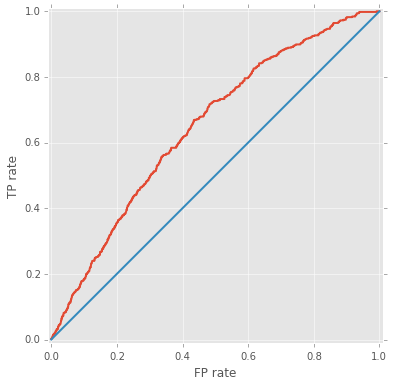

In [6]:
plot_roc(test_y,test_pred_pr[:,1])

### Try balaced set

In [7]:
train_id,train_x,train_y = read_my_data(fname='../prepare_data/balanced_islands_train_feat_vect.csv')
test_id,test_x,test_y = read_my_data(fname='../prepare_data/balanced_islands_test_feat_vect.csv')

Loading data... 
Loading data... 


In [8]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_split=5,n_jobs=14)
train_pred,test_pred,train_pred_pr,test_pred_pr=test_sklearn_model(
    rf,train_x,train_y,test_x,test_y)

train score: 1.0
test score: 0.647524752475
It took: 77.1025118828


auc: 0.694678953044


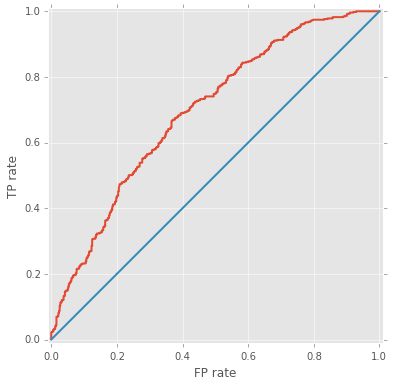

In [9]:
plot_roc(test_y,test_pred_pr[:,1])

### Permute vector

- better separation of at,gc

In [10]:
train_x[train_x==4]=5
train_x[train_x==2]=4
train_x[train_x==5]=2

test_x[test_x==4]=5
test_x[test_x==2]=4
test_x[test_x==5]=2

In [11]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_split=5,n_jobs=14)
train_pred,test_pred,train_pred_pr,test_pred_pr=test_sklearn_model(
    rf,train_x,train_y,test_x,test_y)

train score: 1.0
test score: 0.635643564356
It took: 62.1317601204


auc: 0.714561317518


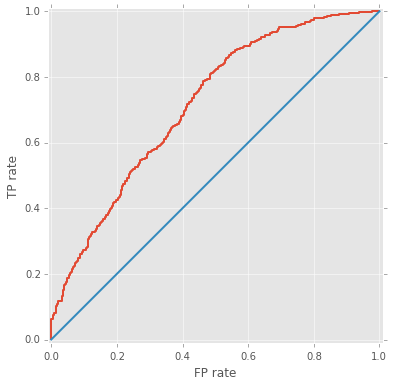

In [12]:
plot_roc(test_y,test_pred_pr[:,1])

### One hot encode data

In [13]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.concatenate([train_x.flatten(),test_x.flatten()]))

one_hot_train_x=lb.transform(train_x.flatten()).reshape((-1,4000))
one_hot_test_x=lb.transform(test_x.flatten()).reshape((-1,4000))

In [14]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_split=5,n_jobs=14)
train_pred,test_pred,train_pred_pr,test_pred_pr=test_sklearn_model(
    rf,one_hot_train_x,train_y,one_hot_test_x,test_y)

train score: 1.0
test score: 0.620792079208
It took: 149.502782106


auc: 0.685217135575


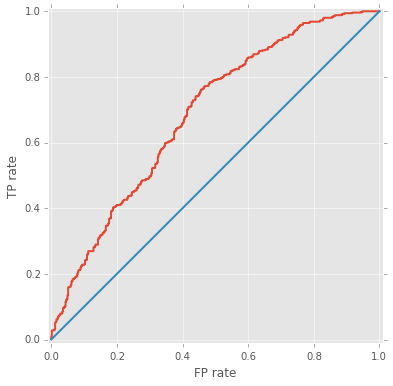

In [15]:
plot_roc(test_y,test_pred_pr[:,1])

---
## Feature importance with Random Forest

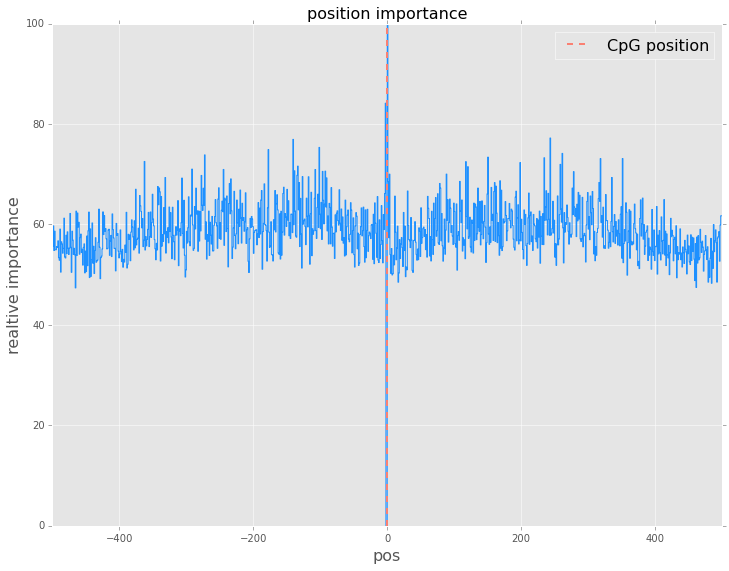

In [16]:
rf = ensemble.RandomForestClassifier(n_estimators=100,min_samples_split=5,n_jobs=12)
model=rf.fit(train_x,train_y)
feature_importance = model.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

fig,ax=plt.subplots()
fig.set_size_inches(12,9)
ax.step(np.arange(len(feature_importance))-500, feature_importance,lw=1,c='dodgerblue')
ax.axvline(0,lw=2,linestyle='dashed',c='salmon',label='CpG position')
ax.set_ylabel('realtive importance',fontsize=16)
ax.set_xlabel('pos',fontsize=16)
ax.set_xlim(-500,500)
ax.legend(fontsize=16)
dump=ax.set_title('position importance',fontsize=16)